#A. Lung Cancer Detection using Convolutional Neural Network (CNN)

The process which will be followed to build this classifier:

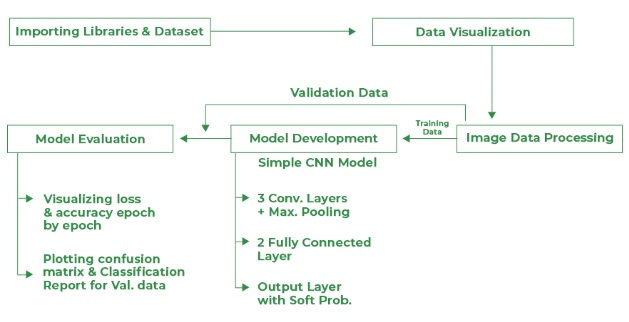

##1. Importing libraries and dataset:

###1.a. Importing libraries:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

###1.b. Importing Dataset:

*   Connect Google Colab to Kaggle to import databases: More details: https://www.youtube.com/watch?v=up8R4jT49Ak

*   Link dataset: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Kaggle Installation
!pip install -q kaggle
#Create Kaggle Folder
!mkdir ~/.kaggle/
# copy kaggle.json in ~/.kaggle/
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' ~/.kaggle/
!chmod 600  ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
cp: cannot stat '/content/drive/MyDrive/Kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


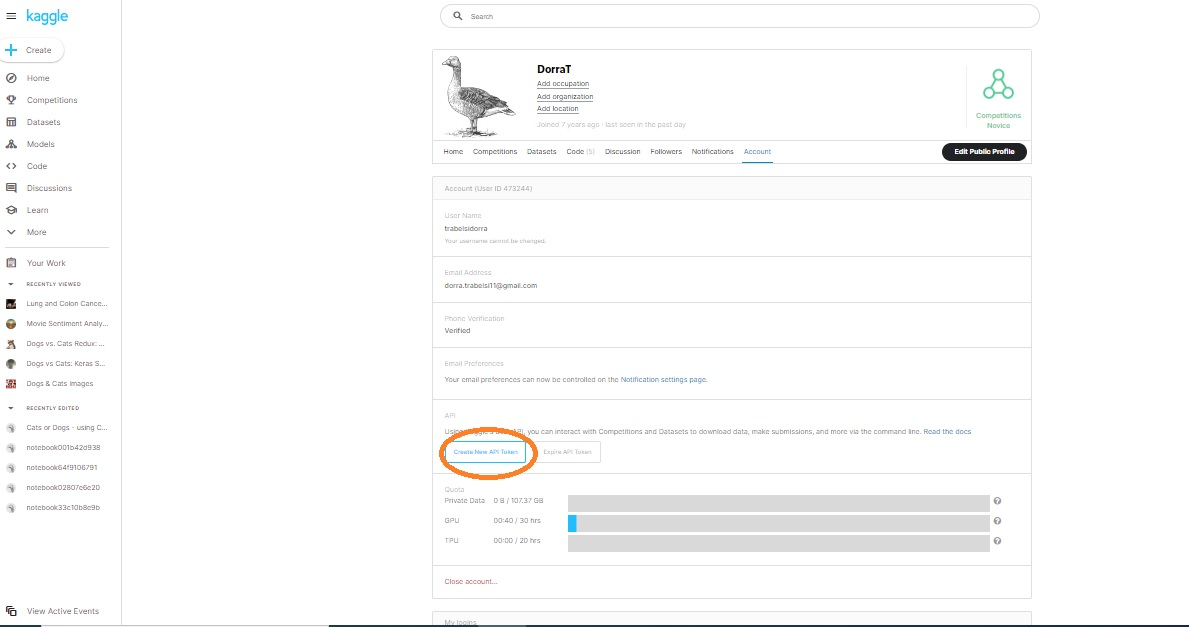

In [ ]:
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!kaggle datasets download andrewmvd/lung-and-colon-cancer-histopathological-images

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


This dataset includes 5000 images for three classes of lung conditions:
*   Normal Class
*   Lung Adenocarcinomas
*   Lung Squamous Cell Carcinomas

In [ ]:
from zipfile import ZipFile
 
data_path = 'lung-and-colon-cancer-histopathological-images.zip'
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

The data set has been extracted.


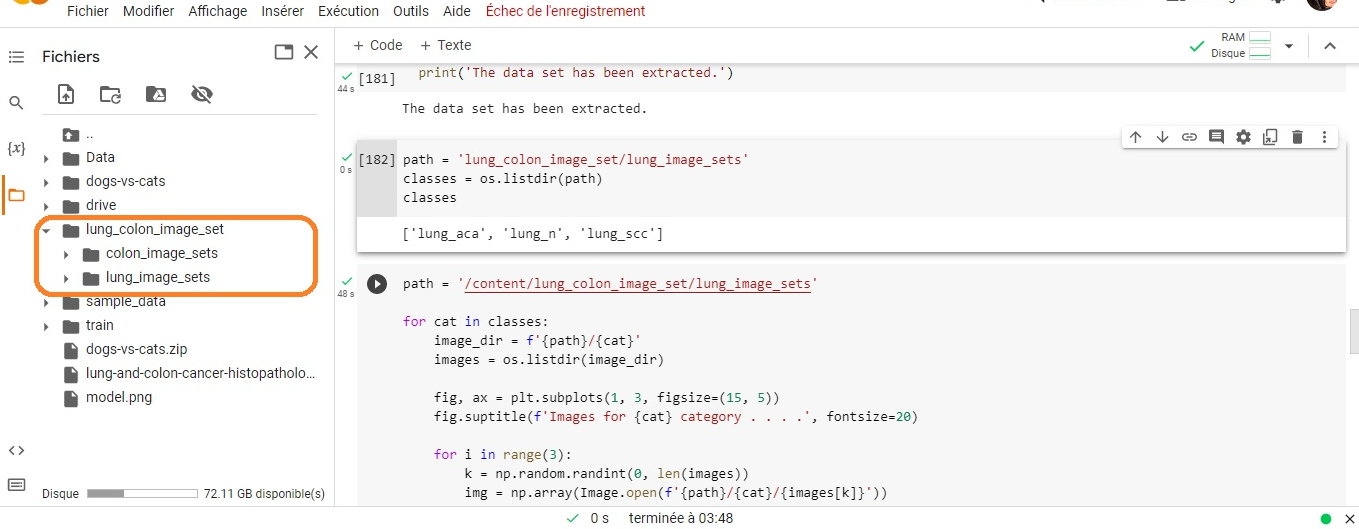

##2. Data Visualization

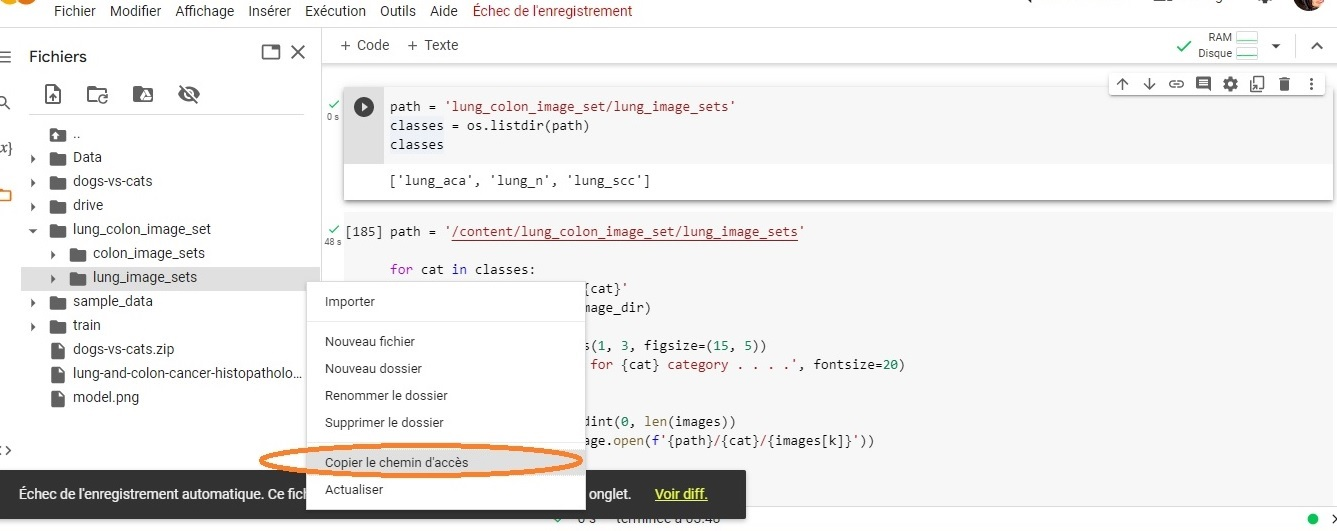

In [ ]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

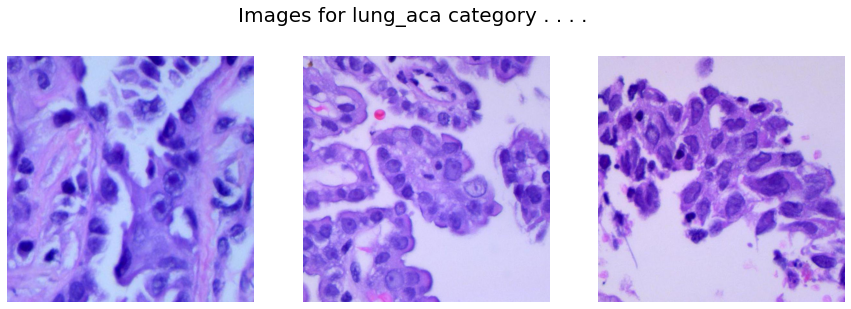

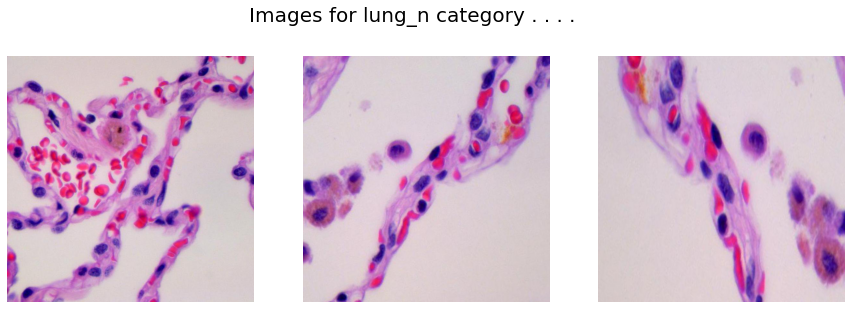

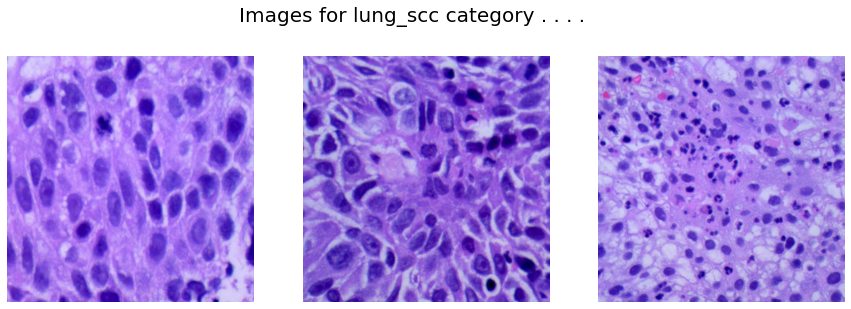

In [ ]:
path = '/content/lung_colon_image_set/lung_image_sets'
 
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

##3. Data Preparation 


In this section, we will convert the given images into NumPy arrays of their pixels after resizing them because training a Deep Neural Network on large-size images is highly inefficient in terms of computational cost and time.

For this purpose, we will use the OpenCV library and Numpy library of python to serve the purpose. Also, after all the images are converted into the desired format we will split them into training and validation data so, that we can evaluate the performance of our model.

In [ ]:
# hyperparameters
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [ ]:
X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values #train a model which can predict soft probabilities of an image being from each class
                                            # with the highest probability for the class to which it really belongs.

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
												test_size = SPLIT,
												random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


##4. Model Development


We will implement a Sequential model which will contain the following parts:

Three Convolutional Layers followed by MaxPooling Layers.
The Flatten layer to flatten the output of the convolutional layer.
Then we will have two fully connected layers followed by the output of the flattened layer.
We have included some BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.
The final layer is the output layer which outputs soft probabilities for the three classes. 

In [ ]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							3),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(3, activation='softmax')
])


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

 The CNN model we have developed contains about 33.5 Million parameters ==> This huge number of parameters and complexity of the model is what helps to achieve a high-performance model which is being used in real-life applications.

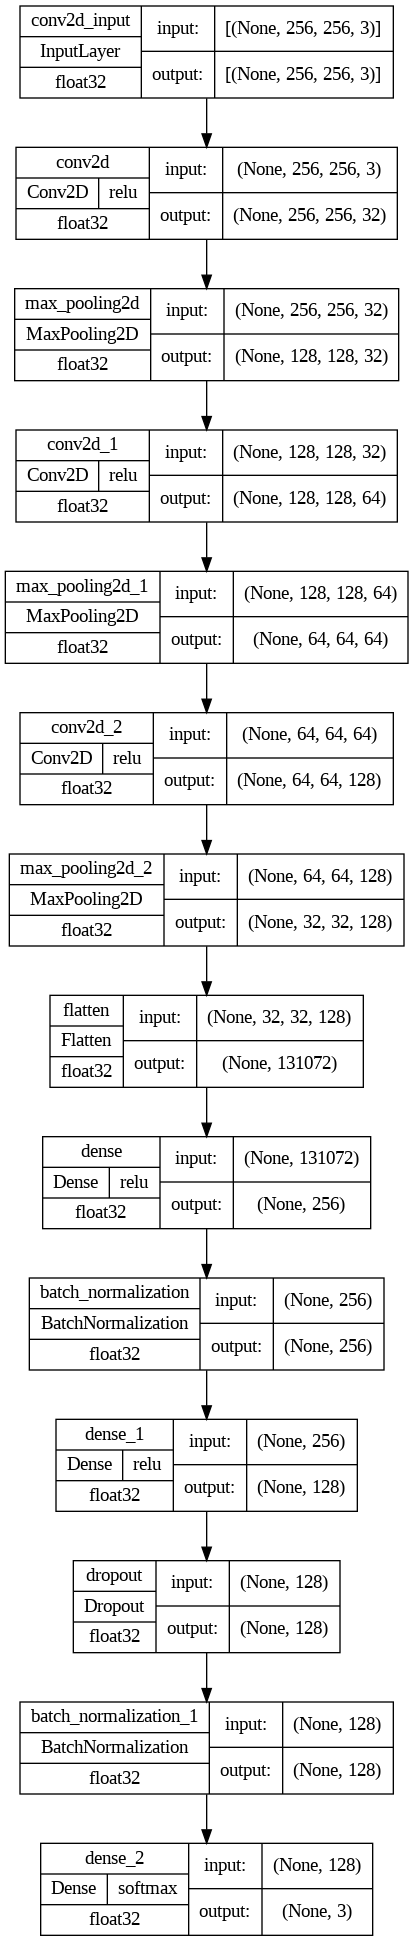

In [ ]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)


In [ ]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


Callbacks are used to check whether the model is improving with each epoch or not. If not then what are the necessary steps to be taken like ReduceLROnPlateau decreases learning rate further. Even then if model performance is not improving then training will be stopped by EarlyStopping. We can also define some custom callbacks to stop training in between if the desired results have been obtained early.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


In [ ]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])



Epoch 1/10
188/188 [==============================] - 2584s 14s/step - loss: 0.3470 - accuracy: 0.8587 - val_loss: 1.8847 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 2505s 13s/step - loss: 0.2076 - accuracy: 0.9188 - val_loss: 5.2042 - val_accuracy: 0.3343 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9364 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 2499s 13s/step - loss: 0.1652 - accuracy: 0.9364 - val_loss: 14.0821 - val_accuracy: 0.4023 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - ETA: 0s - loss: 0.0977 - accuracy: 0.9645 
 Validation accuracy has reached upto 					90% so, stopping further training.
188/188 [==============================] - 2477s 13s/step - loss: 0.0977 - accuracy: 0.9645 - val_loss: 0.2335 - val_accuracy: 0.9273 - lr: 5.0000e-04


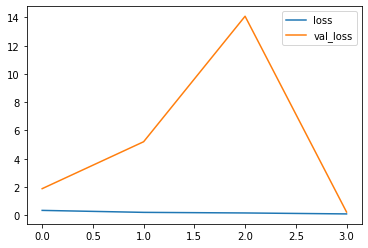

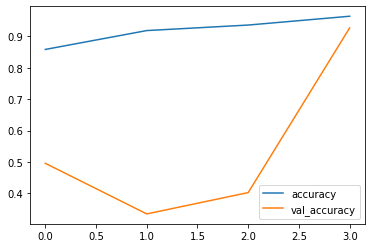

In [ ]:
# Let’s visualize the training and validation accuracy with each epoch
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


From the above graphs, we can certainly say that the model has not overfitted the training data as the difference between the training and validation accuracy is very low.

##5. Model Evaluation

In [ ]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 [==============================] - 160s 2s/step


In [ ]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[885,   0, 102],
       [ 44, 933,   0],
       [ 72,   0, 964]])

In [ ]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.88      0.90      0.89       987
      lung_n       1.00      0.95      0.98       977
    lung_scc       0.90      0.93      0.92      1036

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



The simple CNN model is very good as the **f1-score** for each class is above **0.90** which means our model’s prediction is ***correct 90% of the time***. 

📈This is what we have achieved with a simple CNN model what if we use the Transfer Learning Technique to leverage the pre-trained parameters which have been trained on millions of datasets and for weeks using multiple GPUs? It is highly likely to achieve even better performance on this dataset.

*   **Let's try**  🤩







# B. Lung Cancer Detection Using Transfer Learning

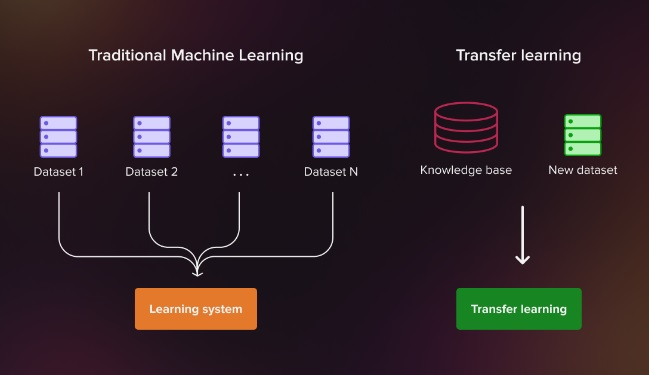

For more details: https://serokell.io/blog/guide-to-transfer-learning

##1. Model Development

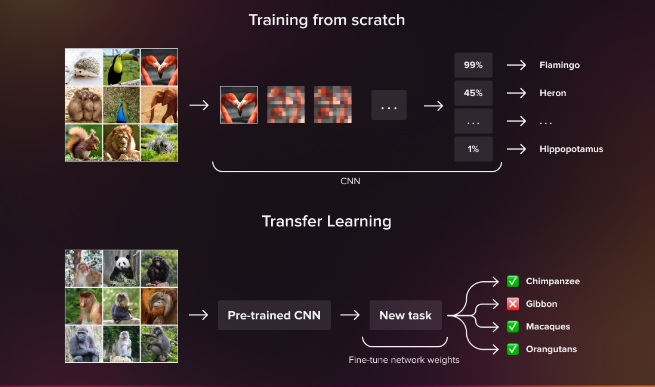

We will use pre-trained weight for an Inception network which is trained on imagenet dataset. This dataset contains millions of images for around 1000 classes of images.

Model Architecture
We will implement a model using the  Functional API of Keras which will contain the following parts:

*   The base model is the Inception model in this case.
*   The Flatten layer flattens the output of the base model’s output.
*   Then we will have two fully connected layers followed by the output of the flattened layer.
*   We have included some BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting.
*  The final layer is the output layer which outputs soft probabilities for the three classes. 

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
	input_shape = (IMG_SIZE, IMG_SIZE, 3),
	weights = 'imagenet',
	include_top = False
)


In [ ]:
len(pre_trained_model.layers)


311


> This is how deep this model is this also justifies why this model is highly effective in extracting useful features from images which helps us to build classifiers.



In [ ]:
for layer in pre_trained_model.layers:
 layer.trainable = False


In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')# Mixed7 is one of the layers in the inception network whose outputs we will use to build the classifier.
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 14, 14, 768)


In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 14, 14, 768)


In [ ]:
x = layers.Flatten()(last_output)

x = layers.Dense(256,activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)


In [ ]:
model.compile(
	optimizer='adam',
	loss='categorical_crossentropy',
	metrics=['accuracy']
)


In [ ]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.90:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True
 
es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)

In [ ]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


Epoch 1/10
188/188 [==============================] - 2030s 11s/step - loss: 0.3899 - accuracy: 0.8451 - val_loss: 1.0294 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 2010s 11s/step - loss: 0.2416 - accuracy: 0.9048 - val_loss: 0.3321 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 0.1762 - accuracy: 0.9312
 Validation accuracy has reached upto 90%      so, stopping further training.
188/188 [==============================] - 2027s 11s/step - loss: 0.1762 - accuracy: 0.9312 - val_loss: 0.1949 - val_accuracy: 0.9313 - lr: 0.0010


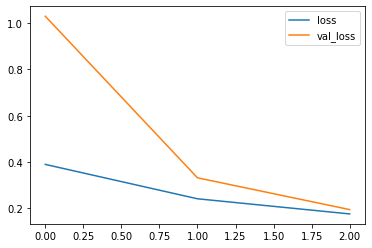

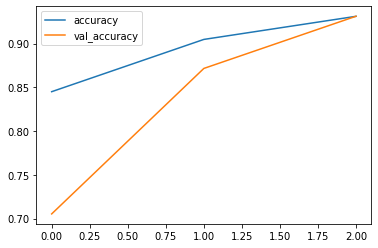

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


From the above graphs, we can certainly say that the model has not overfitted the training data as the difference between the training and validation accuracy is very low.

## 2. Model Evaluation

In [ ]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 [==============================] - 383s 4s/step


In [ ]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[948,   3,  36],
       [ 51, 924,   2],
       [114,   0, 922]])

In [ ]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.85      0.96      0.90       987
      lung_n       1.00      0.95      0.97       977
    lung_scc       0.96      0.89      0.92      1036

    accuracy                           0.93      3000
   macro avg       0.94      0.93      0.93      3000
weighted avg       0.94      0.93      0.93      3000



**CONCLUSION:** the performance of our model using the Transfer Learning Technique has achieved higher accuracy without overfitting which is very good as the f1-score for each class is also above **0.93** which means our model’s prediction is **correct 93% of the time**.